In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dropout, Dense, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# -----------------------------------------------------------
# STATIONS
# -----------------------------------------------------------
stations = {
    "Caracarai": "caracarai.csv",
    "Cucui": "cucui.csv",
    "Moura": "moura.csv",
    "Santa_Maria_do_Boiacu": "santa_maria_do_boiacu.csv",
    "Serrinha": "serrinha.csv"
}

subnet_config = {
    "Caracarai": {"filters": 64, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
    "Cucui": {"filters": 64, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
    "Moura": {"filters": 32, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
    "Santa_Maria_do_Boiacu": {"filters": 32, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
    "Serrinha": {"filters": 32, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
}

# -----------------------------------------------------------
# SUBNETS
# -----------------------------------------------------------
def create_subnet(input_layer, filters, kernel_size, pool_size, dropout_rate):
    x = Conv1D(filters=filters, kernel_size=min(kernel_size, input_layer.shape[1]),
               activation='relu', padding='same')(input_layer)
    x = Conv1D(filters=filters * 2, kernel_size=min(kernel_size, input_layer.shape[1]),
               activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=min(pool_size, input_layer.shape[1]))(x)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(filters=filters, kernel_size=min(kernel_size, x.shape[1]),
               activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=min(pool_size, x.shape[1]))(x)
    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)
    return x

# -----------------------------------------------------------
# sliding window
# -----------------------------------------------------------
def create_sliding_windows(series, window_size=10):
    X, Y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        Y.append(series[i+window_size])
    X = np.array(X).reshape(-1, window_size, 1)
    Y = np.array(Y).reshape(-1, 1)
    return X, Y

def process_data(file_path, window_size=10):
    df = pd.read_csv(file_path)
    series = df.iloc[:, -2].values / 100  

    X, Y = create_sliding_windows(series, window_size)

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X = scaler_x.fit_transform(X.reshape(-1, window_size)).reshape(-1, window_size, 1)
    Y = scaler_y.fit_transform(Y)

    return X, Y, scaler_y

station_data = {s: process_data(f) for s, f in stations.items()}

# -----------------------------------------------------------
# GLOBAL MODEL WITH 5 OUTPUT
# -----------------------------------------------------------
inputs = {}
subnets = {}
for station, config in subnet_config.items():
    inp = Input(shape=(10, 1), name=f"input_{station}")
    sub = create_subnet(inp, **config)
    inputs[station] = inp
    subnets[station] = sub

merged = concatenate(list(subnets.values()), name="merged_layer")
dense_1 = Dense(60, activation='relu', kernel_regularizer=l2(0.005))(merged)
dense_2 = Dense(30, activation='relu', kernel_regularizer=l2(0.005))(dense_1)

outputs = {station: Dense(1, name=f"output_{station}")(dense_2) for station in stations}



model = Model(inputs=list(inputs.values()), outputs=list(outputs.values()))
losses = {f"output_{st}": "mse" for st in stations}
metrics = {f"output_{st}": ["mae"] for st in stations}
model.compile(optimizer=Adam(0.001), loss=losses, metrics=metrics)

# -----------------------------------------------------------
# TRAIN
# -----------------------------------------------------------
X_all = {f"input_{st}": station_data[st][0] for st in stations}
Y_all = {f"output_{st}": station_data[st][1] for st in stations}

history = model.fit(
    X_all,
    Y_all,
    epochs=1000,
    validation_split=0.2,  # agora automático, mantém toda a série
    verbose=1
)

# -----------------------------------------------------------
# OUTPUT
# -----------------------------------------------------------
for station in stations:
    X_test, Y_test, scaler_y = station_data[station]
    X_inputs = {f"input_{s}": station_data[s][0] for s in stations}
    idx = list(stations.keys()).index(station)
    preds = model.predict(X_inputs)[idx]
    preds_rescaled = scaler_y.inverse_transform(preds)
    real_rescaled  = scaler_y.inverse_transform(Y_test)
    df_out = pd.DataFrame({"Observed": real_rescaled.flatten(),
                           "Predicted": preds_rescaled.flatten()})
    df_out.to_csv(f"{station}_previsoes.csv", index=False)
    print(f"Gerado: {station}_previsoes.csv")


2025-12-08 17:34:58.162332: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 17:34:58.174306: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-08 17:34:58.290496: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-08 17:34:58.402130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765229698.501040    7097 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765229698.53

Epoch 1/1000


/home/carlos/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_Caracarai', 'input_Cucui', 'input_Moura', 'input_Santa_Maria_do_Boiacu', 'input_Serrinha']. Received: the structure of inputs={'input_Caracarai': '*', 'input_Cucui': '*', 'input_Moura': '*', 'input_Santa_Maria_do_Boiacu': '*', 'input_Serrinha': '*'}
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 2.0323 - output_Caracarai_loss: 0.2896 - output_Caracarai_mae: 0.4358 - output_Cucui_loss: 0.4415 - output_Cucui_mae: 0.5953 - output_Moura_loss: 0.1923 - output_Moura_mae: 0.3590 - output_Santa_Maria_do_Boiacu_loss: 0.1490 - output_Santa_Maria_do_Boiacu_mae: 0.3148 - output_Serrinha_loss: 0.2312 - output_Serrinha_mae: 0.4101 - val_loss: 0.7757 - val_output_Caracarai_loss: 0.0309 - val_output_Caracarai_mae: 0.1423 - val_output_Cucui_loss: 0.0024 - val_output_Cucui_mae: 0.0432 - val_output_Moura_loss: 0.0155 - val_output_Moura_mae: 0.1338 - val_output_Santa_Maria_do_Boiacu_loss: 0.0021 - val_output_Santa_Maria_do_Boiacu_mae: 0.0372 - val_output_Serrinha_loss: 0.0270 - val_output_Serrinha_mae: 0.1564
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9604 - output_Caracarai_loss: 0.0861 - output_Caracarai_mae: 0.2449 - output_Cucui_loss: 0.0593 - output_Cucui_mae: 0.1876 - output_Moura_loss: 0.0481 - output_Moura_mae: 0.1772 - outpu

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2589 - output_Caracarai_loss: 0.0115 - output_Caracarai_mae: 0.0797 - output_Cucui_loss: 0.0064 - output_Cucui_mae: 0.0639 - output_Moura_loss: 0.0104 - output_Moura_mae: 0.0793 - output_Santa_Maria_do_Boiacu_loss: 0.0059 - output_Santa_Maria_do_Boiacu_mae: 0.0594 - output_Serrinha_loss: 0.0108 - output_Serrinha_mae: 0.0814 - val_loss: 0.2670 - val_output_Caracarai_loss: 0.0073 - val_output_Caracarai_mae: 0.0782 - val_output_Cucui_loss: 0.0074 - val_output_Cucui_mae: 0.0776 - val_output_Moura_loss: 0.0260 - val_output_Moura_mae: 0.1746 - val_output_Santa_Maria_do_Boiacu_loss: 0.0060 - val_output_Santa_Maria_do_Boiacu_mae: 0.0615 - val_output_Serrinha_loss: 0.0039 - val_output_Serrinha_mae: 0.0551
Epoch 22/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2523 - output_Caracarai_loss: 0.0114 - output_Caracarai_mae: 0.0800 - output_Cucui_loss: 0.0075 - output_Cucui_mae: 0.0653 - output_Moura_loss: 0.0106 - output_Moura_mae: 0.0835 - outp

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1251 - output_Caracarai_loss: 0.0074 - output_Caracarai_mae: 0.0633 - output_Cucui_loss: 0.0043 - output_Cucui_mae: 0.0524 - output_Moura_loss: 0.0062 - output_Moura_mae: 0.0633 - output_Santa_Maria_do_Boiacu_loss: 0.0052 - output_Santa_Maria_do_Boiacu_mae: 0.0560 - output_Serrinha_loss: 0.0060 - output_Serrinha_mae: 0.0605 - val_loss: 0.1449 - val_output_Caracarai_loss: 0.0066 - val_output_Caracarai_mae: 0.0754 - val_output_Cucui_loss: 0.0072 - val_output_Cucui_mae: 0.0719 - val_output_Moura_loss: 0.0205 - val_output_Moura_mae: 0.1506 - val_output_Santa_Maria_do_Boiacu_loss: 0.0048 - val_output_Santa_Maria_do_Boiacu_mae: 0.0550 - val_output_Serrinha_loss: 0.0043 - val_output_Serrinha_mae: 0.0574
Epoch 42/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1198 - output_Caracarai_loss: 0.0071 - output_Caracarai_mae: 0.0645 - output_Cucui_loss: 0.0042 - output_Cucui_mae: 0.0526 - output_Moura_loss: 0.0054 - output_Moura_mae: 0.0593 - outp

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0744 - output_Caracarai_loss: 0.0059 - output_Caracarai_mae: 0.0606 - output_Cucui_loss: 0.0030 - output_Cucui_mae: 0.0428 - output_Moura_loss: 0.0045 - output_Moura_mae: 0.0531 - output_Santa_Maria_do_Boiacu_loss: 0.0034 - output_Santa_Maria_do_Boiacu_mae: 0.0446 - output_Serrinha_loss: 0.0034 - output_Serrinha_mae: 0.0460 - val_loss: 0.1038 - val_output_Caracarai_loss: 0.0118 - val_output_Caracarai_mae: 0.1013 - val_output_Cucui_loss: 0.0051 - val_output_Cucui_mae: 0.0590 - val_output_Moura_loss: 0.0167 - val_output_Moura_mae: 0.1337 - val_output_Santa_Maria_do_Boiacu_loss: 0.0058 - val_output_Santa_Maria_do_Boiacu_mae: 0.0624 - val_output_Serrinha_loss: 0.0055 - val_output_Serrinha_mae: 0.0662
Epoch 62/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0766 - output_Caracarai_loss: 0.0083 - output_Caracarai_mae: 0.0623 - output_Cucui_loss: 0.0034 - output_Cucui_mae: 0.0445 - output_Moura_loss: 0.0043 - output_Moura_mae: 0.0507 - outp

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0508 - output_Caracarai_loss: 0.0039 - output_Caracarai_mae: 0.0479 - output_Cucui_loss: 0.0026 - output_Cucui_mae: 0.0392 - output_Moura_loss: 0.0035 - output_Moura_mae: 0.0477 - output_Santa_Maria_do_Boiacu_loss: 0.0025 - output_Santa_Maria_do_Boiacu_mae: 0.0396 - output_Serrinha_loss: 0.0035 - output_Serrinha_mae: 0.0466 - val_loss: 0.0767 - val_output_Caracarai_loss: 0.0090 - val_output_Caracarai_mae: 0.0854 - val_output_Cucui_loss: 0.0041 - val_output_Cucui_mae: 0.0509 - val_output_Moura_loss: 0.0152 - val_output_Moura_mae: 0.1250 - val_output_Santa_Maria_do_Boiacu_loss: 0.0047 - val_output_Santa_Maria_do_Boiacu_mae: 0.0525 - val_output_Serrinha_loss: 0.0047 - val_output_Serrinha_mae: 0.0602
Epoch 82/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0498 - output_Caracarai_loss: 0.0041 - output_Caracarai_mae: 0.0487 - output_Cucui_loss: 0.0026 - output_Cucui_mae: 0.0407 - output_Moura_loss: 0.0033 - output_Moura_mae: 0.0464 - outp

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0428 - output_Caracarai_loss: 0.0048 - output_Caracarai_mae: 0.0518 - output_Cucui_loss: 0.0032 - output_Cucui_mae: 0.0425 - output_Moura_loss: 0.0038 - output_Moura_mae: 0.0484 - output_Santa_Maria_do_Boiacu_loss: 0.0034 - output_Santa_Maria_do_Boiacu_mae: 0.0454 - output_Serrinha_loss: 0.0031 - output_Serrinha_mae: 0.0437 - val_loss: 0.0538 - val_output_Caracarai_loss: 0.0044 - val_output_Caracarai_mae: 0.0610 - val_output_Cucui_loss: 0.0017 - val_output_Cucui_mae: 0.0318 - val_output_Moura_loss: 0.0118 - val_output_Moura_mae: 0.1073 - val_output_Santa_Maria_do_Boiacu_loss: 0.0040 - val_output_Santa_Maria_do_Boiacu_mae: 0.0500 - val_output_Serrinha_loss: 0.0032 - val_output_Serrinha_mae: 0.0512
Epoch 102/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0407 - output_Caracarai_loss: 0.0052 - output_Caracarai_mae: 0.0510 - output_Cucui_loss: 0.0022 - output_Cucui_mae: 0.0370 - output_Moura_loss: 0.0030 - output_Moura_mae: 0.0421 - out

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0342 - output_Caracarai_loss: 0.0035 - output_Caracarai_mae: 0.0442 - output_Cucui_loss: 0.0022 - output_Cucui_mae: 0.0375 - output_Moura_loss: 0.0031 - output_Moura_mae: 0.0439 - output_Santa_Maria_do_Boiacu_loss: 0.0030 - output_Santa_Maria_do_Boiacu_mae: 0.0427 - output_Serrinha_loss: 0.0041 - output_Serrinha_mae: 0.0483 - val_loss: 0.0384 - val_output_Caracarai_loss: 0.0026 - val_output_Caracarai_mae: 0.0493 - val_output_Cucui_loss: 0.0014 - val_output_Cucui_mae: 0.0271 - val_output_Moura_loss: 0.0071 - val_output_Moura_mae: 0.0819 - val_output_Santa_Maria_do_Boiacu_loss: 0.0024 - val_output_Santa_Maria_do_Boiacu_mae: 0.0388 - val_output_Serrinha_loss: 0.0033 - val_output_Serrinha_mae: 0.0532
Epoch 122/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0330 - output_Caracarai_loss: 0.0038 - output_Caracarai_mae: 0.0444 - output_Cucui_loss: 0.0024 - output_Cucui_mae: 0.0380 - output_Moura_loss: 0.0028 - output_Moura_mae: 0.0390 - out

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0261 - output_Caracarai_loss: 0.0028 - output_Caracarai_mae: 0.0389 - output_Cucui_loss: 0.0017 - output_Cucui_mae: 0.0319 - output_Moura_loss: 0.0021 - output_Moura_mae: 0.0360 - output_Santa_Maria_do_Boiacu_loss: 0.0018 - output_Santa_Maria_do_Boiacu_mae: 0.0326 - output_Serrinha_loss: 0.0032 - output_Serrinha_mae: 0.0452 - val_loss: 0.0347 - val_output_Caracarai_loss: 0.0037 - val_output_Caracarai_mae: 0.0562 - val_output_Cucui_loss: 0.0011 - val_output_Cucui_mae: 0.0230 - val_output_Moura_loss: 0.0077 - val_output_Moura_mae: 0.0844 - val_output_Santa_Maria_do_Boiacu_loss: 0.0028 - val_output_Santa_Maria_do_Boiacu_mae: 0.0403 - val_output_Serrinha_loss: 0.0025 - val_output_Serrinha_mae: 0.0461
Epoch 142/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0266 - output_Caracarai_loss: 0.0028 - output_Caracarai_mae: 0.0393 - output_Cucui_loss: 0.0023 - output_Cucui_mae: 0.0366 - output_Moura_loss: 0.0026 - output_Moura_mae: 0.0390 - out

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0216 - output_Caracarai_loss: 0.0026 - output_Caracarai_mae: 0.0388 - output_Cucui_loss: 0.0016 - output_Cucui_mae: 0.0313 - output_Moura_loss: 0.0017 - output_Moura_mae: 0.0329 - output_Santa_Maria_do_Boiacu_loss: 0.0018 - output_Santa_Maria_do_Boiacu_mae: 0.0350 - output_Serrinha_loss: 0.0022 - output_Serrinha_mae: 0.0376 - val_loss: 0.0310 - val_output_Caracarai_loss: 0.0030 - val_output_Caracarai_mae: 0.0519 - val_output_Cucui_loss: 0.0014 - val_output_Cucui_mae: 0.0270 - val_output_Moura_loss: 0.0076 - val_output_Moura_mae: 0.0829 - val_output_Santa_Maria_do_Boiacu_loss: 0.0030 - val_output_Santa_Maria_do_Boiacu_mae: 0.0407 - val_output_Serrinha_loss: 0.0020 - val_output_Serrinha_mae: 0.0389
Epoch 162/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0215 - output_Caracarai_loss: 0.0026 - output_Caracarai_mae: 0.0377 - output_Cucui_loss: 0.0017 - output_Cucui_mae: 0.0314 - output_Moura_loss: 0.0019 - output_Moura_mae: 0.0332 - out

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0196 - output_Caracarai_loss: 0.0026 - output_Caracarai_mae: 0.0397 - output_Cucui_loss: 0.0018 - output_Cucui_mae: 0.0327 - output_Moura_loss: 0.0017 - output_Moura_mae: 0.0328 - output_Santa_Maria_do_Boiacu_loss: 0.0019 - output_Santa_Maria_do_Boiacu_mae: 0.0343 - output_Serrinha_loss: 0.0021 - output_Serrinha_mae: 0.0342 - val_loss: 0.0306 - val_output_Caracarai_loss: 0.0070 - val_output_Caracarai_mae: 0.0748 - val_output_Cucui_loss: 0.0018 - val_output_Cucui_mae: 0.0337 - val_output_Moura_loss: 0.0054 - val_output_Moura_mae: 0.0669 - val_output_Santa_Maria_do_Boiacu_loss: 0.0031 - val_output_Santa_Maria_do_Boiacu_mae: 0.0417 - val_output_Serrinha_loss: 0.0025 - val_output_Serrinha_mae: 0.0470
Epoch 182/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0189 - output_Caracarai_loss: 0.0023 - output_Caracarai_mae: 0.0358 - output_Cucui_loss: 0.0019 - output_Cucui_mae: 0.0327 - output_Moura_loss: 0.0017 - output_Moura_mae: 0.0321 - out

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0168 - output_Caracarai_loss: 0.0025 - output_Caracarai_mae: 0.0370 - output_Cucui_loss: 0.0016 - output_Cucui_mae: 0.0308 - output_Moura_loss: 0.0014 - output_Moura_mae: 0.0287 - output_Santa_Maria_do_Boiacu_loss: 0.0015 - output_Santa_Maria_do_Boiacu_mae: 0.0301 - output_Serrinha_loss: 0.0019 - output_Serrinha_mae: 0.0337 - val_loss: 0.0279 - val_output_Caracarai_loss: 0.0036 - val_output_Caracarai_mae: 0.0563 - val_output_Cucui_loss: 0.0011 - val_output_Cucui_mae: 0.0240 - val_output_Moura_loss: 0.0074 - val_output_Moura_mae: 0.0823 - val_output_Santa_Maria_do_Boiacu_loss: 0.0021 - val_output_Santa_Maria_do_Boiacu_mae: 0.0364 - val_output_Serrinha_loss: 0.0023 - val_output_Serrinha_mae: 0.0446
Epoch 202/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0172 - output_Caracarai_loss: 0.0028 - output_Caracarai_mae: 0.0414 - output_Cucui_loss: 0.0017 - output_Cucui_mae: 0.0321 - output_Moura_loss: 0.0014 - output_Moura_mae: 0.0293 - out

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0172 - output_Caracarai_loss: 0.0025 - output_Caracarai_mae: 0.0375 - output_Cucui_loss: 0.0018 - output_Cucui_mae: 0.0336 - output_Moura_loss: 0.0021 - output_Moura_mae: 0.0366 - output_Santa_Maria_do_Boiacu_loss: 0.0020 - output_Santa_Maria_do_Boiacu_mae: 0.0354 - output_Serrinha_loss: 0.0018 - output_Serrinha_mae: 0.0340 - val_loss: 0.0319 - val_output_Caracarai_loss: 0.0029 - val_output_Caracarai_mae: 0.0514 - val_output_Cucui_loss: 0.0013 - val_output_Cucui_mae: 0.0261 - val_output_Moura_loss: 0.0102 - val_output_Moura_mae: 0.1010 - val_output_Santa_Maria_do_Boiacu_loss: 0.0018 - val_output_Santa_Maria_do_Boiacu_mae: 0.0368 - val_output_Serrinha_loss: 0.0036 - val_output_Serrinha_mae: 0.0594
Epoch 222/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0174 - output_Caracarai_loss: 0.0024 - output_Caracarai_mae: 0.0376 - output_Cucui_loss: 0.0021 - output_Cucui_mae: 0.0354 - output_Moura_loss: 0.0018 - output_Moura_mae: 0.0326 - out

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0142 - output_Caracarai_loss: 0.0022 - output_Caracarai_mae: 0.0356 - output_Cucui_loss: 0.0015 - output_Cucui_mae: 0.0285 - output_Moura_loss: 0.0012 - output_Moura_mae: 0.0262 - output_Santa_Maria_do_Boiacu_loss: 0.0015 - output_Santa_Maria_do_Boiacu_mae: 0.0292 - output_Serrinha_loss: 0.0017 - output_Serrinha_mae: 0.0316 - val_loss: 0.0238 - val_output_Caracarai_loss: 0.0032 - val_output_Caracarai_mae: 0.0523 - val_output_Cucui_loss: 0.0012 - val_output_Cucui_mae: 0.0258 - val_output_Moura_loss: 0.0063 - val_output_Moura_mae: 0.0748 - val_output_Santa_Maria_do_Boiacu_loss: 0.0022 - val_output_Santa_Maria_do_Boiacu_mae: 0.0372 - val_output_Serrinha_loss: 0.0021 - val_output_Serrinha_mae: 0.0430
Epoch 242/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0143 - output_Caracarai_loss: 0.0019 - output_Caracarai_mae: 0.0331 - output_Cucui_loss: 0.0017 - output_Cucui_mae: 0.0317 - output_Moura_loss: 0.0012 - output_Moura_mae: 0.0272 - out

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0134 - output_Caracarai_loss: 0.0020 - output_Caracarai_mae: 0.0345 - output_Cucui_loss: 0.0015 - output_Cucui_mae: 0.0282 - output_Moura_loss: 0.0013 - output_Moura_mae: 0.0277 - output_Santa_Maria_do_Boiacu_loss: 0.0016 - output_Santa_Maria_do_Boiacu_mae: 0.0314 - output_Serrinha_loss: 0.0016 - output_Serrinha_mae: 0.0306 - val_loss: 0.0207 - val_output_Caracarai_loss: 0.0023 - val_output_Caracarai_mae: 0.0470 - val_output_Cucui_loss: 9.8671e-04 - val_output_Cucui_mae: 0.0242 - val_output_Moura_loss: 0.0047 - val_output_Moura_mae: 0.0638 - val_output_Santa_Maria_do_Boiacu_loss: 0.0019 - val_output_Santa_Maria_do_Boiacu_mae: 0.0372 - val_output_Serrinha_loss: 0.0024 - val_output_Serrinha_mae: 0.0452
Epoch 262/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0134 - output_Caracarai_loss: 0.0023 - output_Caracarai_mae: 0.0358 - output_Cucui_loss: 0.0013 - output_Cucui_mae: 0.0265 - output_Moura_loss: 0.0014 - output_Moura_mae: 0.0292 -

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0137 - output_Caracarai_loss: 0.0027 - output_Caracarai_mae: 0.0390 - output_Cucui_loss: 0.0015 - output_Cucui_mae: 0.0293 - output_Moura_loss: 0.0014 - output_Moura_mae: 0.0288 - output_Santa_Maria_do_Boiacu_loss: 0.0017 - output_Santa_Maria_do_Boiacu_mae: 0.0304 - output_Serrinha_loss: 0.0015 - output_Serrinha_mae: 0.0302 - val_loss: 0.0229 - val_output_Caracarai_loss: 0.0032 - val_output_Caracarai_mae: 0.0541 - val_output_Cucui_loss: 0.0011 - val_output_Cucui_mae: 0.0239 - val_output_Moura_loss: 0.0060 - val_output_Moura_mae: 0.0727 - val_output_Santa_Maria_do_Boiacu_loss: 0.0017 - val_output_Santa_Maria_do_Boiacu_mae: 0.0346 - val_output_Serrinha_loss: 0.0029 - val_output_Serrinha_mae: 0.0522
Epoch 282/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0130 - output_Caracarai_loss: 0.0023 - output_Caracarai_mae: 0.0361 - output_Cucui_loss: 0.0012 - output_Cucui_mae: 0.0262 - output_Moura_loss: 0.0013 - output_Moura_mae: 0.0277 - out

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0112 - output_Caracarai_loss: 0.0017 - output_Caracarai_mae: 0.0317 - output_Cucui_loss: 0.0012 - output_Cucui_mae: 0.0264 - output_Moura_loss: 0.0012 - output_Moura_mae: 0.0271 - output_Santa_Maria_do_Boiacu_loss: 0.0013 - output_Santa_Maria_do_Boiacu_mae: 0.0293 - output_Serrinha_loss: 0.0014 - output_Serrinha_mae: 0.0283 - val_loss: 0.0178 - val_output_Caracarai_loss: 0.0044 - val_output_Caracarai_mae: 0.0616 - val_output_Cucui_loss: 0.0015 - val_output_Cucui_mae: 0.0317 - val_output_Moura_loss: 0.0025 - val_output_Moura_mae: 0.0469 - val_output_Santa_Maria_do_Boiacu_loss: 0.0032 - val_output_Santa_Maria_do_Boiacu_mae: 0.0459 - val_output_Serrinha_loss: 7.1982e-04 - val_output_Serrinha_mae: 0.0244
Epoch 302/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0119 - output_Caracarai_loss: 0.0019 - output_Caracarai_mae: 0.0329 - output_Cucui_loss: 0.0017 - output_Cucui_mae: 0.0311 - output_Moura_loss: 0.0012 - output_Moura_mae: 0.0274 -

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0116 - output_Caracarai_loss: 0.0017 - output_Caracarai_mae: 0.0329 - output_Cucui_loss: 0.0014 - output_Cucui_mae: 0.0284 - output_Moura_loss: 0.0011 - output_Moura_mae: 0.0266 - output_Santa_Maria_do_Boiacu_loss: 0.0016 - output_Santa_Maria_do_Boiacu_mae: 0.0311 - output_Serrinha_loss: 0.0015 - output_Serrinha_mae: 0.0296 - val_loss: 0.0209 - val_output_Caracarai_loss: 0.0032 - val_output_Caracarai_mae: 0.0554 - val_output_Cucui_loss: 0.0013 - val_output_Cucui_mae: 0.0276 - val_output_Moura_loss: 0.0051 - val_output_Moura_mae: 0.0665 - val_output_Santa_Maria_do_Boiacu_loss: 0.0017 - val_output_Santa_Maria_do_Boiacu_mae: 0.0339 - val_output_Serrinha_loss: 0.0022 - val_output_Serrinha_mae: 0.0450
Epoch 322/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0117 - output_Caracarai_loss: 0.0021 - output_Caracarai_mae: 0.0346 - output_Cucui_loss: 0.0016 - output_Cucui_mae: 0.0313 - output_Moura_loss: 0.0011 - output_Moura_mae: 0.0262 - out

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0101 - output_Caracarai_loss: 0.0015 - output_Caracarai_mae: 0.0304 - output_Cucui_loss: 0.0013 - output_Cucui_mae: 0.0285 - output_Moura_loss: 0.0010 - output_Moura_mae: 0.0249 - output_Santa_Maria_do_Boiacu_loss: 0.0010 - output_Santa_Maria_do_Boiacu_mae: 0.0256 - output_Serrinha_loss: 0.0013 - output_Serrinha_mae: 0.0275 - val_loss: 0.0187 - val_output_Caracarai_loss: 0.0033 - val_output_Caracarai_mae: 0.0548 - val_output_Cucui_loss: 0.0013 - val_output_Cucui_mae: 0.0289 - val_output_Moura_loss: 0.0041 - val_output_Moura_mae: 0.0591 - val_output_Santa_Maria_do_Boiacu_loss: 0.0022 - val_output_Santa_Maria_do_Boiacu_mae: 0.0381 - val_output_Serrinha_loss: 0.0016 - val_output_Serrinha_mae: 0.0360
Epoch 342/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0103 - output_Caracarai_loss: 0.0017 - output_Caracarai_mae: 0.0316 - output_Cucui_loss: 0.0013 - output_Cucui_mae: 0.0276 - output_Moura_loss: 0.0010 - output_Moura_mae: 0.0249 - out

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0102 - output_Caracarai_loss: 0.0017 - output_Caracarai_mae: 0.0319 - output_Cucui_loss: 0.0011 - output_Cucui_mae: 0.0252 - output_Moura_loss: 7.9017e-04 - output_Moura_mae: 0.0225 - output_Santa_Maria_do_Boiacu_loss: 0.0010 - output_Santa_Maria_do_Boiacu_mae: 0.0246 - output_Serrinha_loss: 0.0019 - output_Serrinha_mae: 0.0315 - val_loss: 0.0209 - val_output_Caracarai_loss: 0.0035 - val_output_Caracarai_mae: 0.0553 - val_output_Cucui_loss: 0.0012 - val_output_Cucui_mae: 0.0277 - val_output_Moura_loss: 0.0055 - val_output_Moura_mae: 0.0678 - val_output_Santa_Maria_do_Boiacu_loss: 0.0017 - val_output_Santa_Maria_do_Boiacu_mae: 0.0335 - val_output_Serrinha_loss: 0.0020 - val_output_Serrinha_mae: 0.0426
Epoch 362/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0092 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0258 - output_Cucui_loss: 0.0012 - output_Cucui_mae: 0.0260 - output_Moura_loss: 9.3019e-04 - output_Moura_mae: 0.02

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0109 - output_Caracarai_loss: 0.0021 - output_Caracarai_mae: 0.0341 - output_Cucui_loss: 0.0014 - output_Cucui_mae: 0.0274 - output_Moura_loss: 0.0011 - output_Moura_mae: 0.0266 - output_Santa_Maria_do_Boiacu_loss: 0.0013 - output_Santa_Maria_do_Boiacu_mae: 0.0292 - output_Serrinha_loss: 0.0014 - output_Serrinha_mae: 0.0286 - val_loss: 0.0185 - val_output_Caracarai_loss: 0.0037 - val_output_Caracarai_mae: 0.0577 - val_output_Cucui_loss: 0.0013 - val_output_Cucui_mae: 0.0275 - val_output_Moura_loss: 0.0045 - val_output_Moura_mae: 0.0606 - val_output_Santa_Maria_do_Boiacu_loss: 0.0028 - val_output_Santa_Maria_do_Boiacu_mae: 0.0423 - val_output_Serrinha_loss: 5.2467e-04 - val_output_Serrinha_mae: 0.0201
Epoch 382/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0103 - output_Caracarai_loss: 0.0023 - output_Caracarai_mae: 0.0342 - output_Cucui_loss: 0.0011 - output_Cucui_mae: 0.0251 - output_Moura_loss: 8.6735e-04 - output_Moura_mae: 0.02

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0089 - output_Caracarai_loss: 0.0013 - output_Caracarai_mae: 0.0280 - output_Cucui_loss: 0.0011 - output_Cucui_mae: 0.0254 - output_Moura_loss: 8.2846e-04 - output_Moura_mae: 0.0236 - output_Santa_Maria_do_Boiacu_loss: 9.1461e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0241 - output_Serrinha_loss: 0.0014 - output_Serrinha_mae: 0.0272 - val_loss: 0.0178 - val_output_Caracarai_loss: 0.0042 - val_output_Caracarai_mae: 0.0584 - val_output_Cucui_loss: 0.0011 - val_output_Cucui_mae: 0.0236 - val_output_Moura_loss: 0.0044 - val_output_Moura_mae: 0.0605 - val_output_Santa_Maria_do_Boiacu_loss: 0.0020 - val_output_Santa_Maria_do_Boiacu_mae: 0.0357 - val_output_Serrinha_loss: 8.6660e-04 - val_output_Serrinha_mae: 0.0264
Epoch 402/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0095 - output_Caracarai_loss: 0.0018 - output_Caracarai_mae: 0.0312 - output_Cucui_loss: 0.0013 - output_Cucui_mae: 0.0272 - output_Moura_loss: 8.4776e-04 - output_Moura_m

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0081 - output_Caracarai_loss: 0.0014 - output_Caracarai_mae: 0.0287 - output_Cucui_loss: 8.8375e-04 - output_Cucui_mae: 0.0231 - output_Moura_loss: 7.4778e-04 - output_Moura_mae: 0.0209 - output_Santa_Maria_do_Boiacu_loss: 8.0341e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0219 - output_Serrinha_loss: 0.0010 - output_Serrinha_mae: 0.0261 - val_loss: 0.0177 - val_output_Caracarai_loss: 0.0033 - val_output_Caracarai_mae: 0.0547 - val_output_Cucui_loss: 0.0013 - val_output_Cucui_mae: 0.0299 - val_output_Moura_loss: 0.0039 - val_output_Moura_mae: 0.0568 - val_output_Santa_Maria_do_Boiacu_loss: 0.0025 - val_output_Santa_Maria_do_Boiacu_mae: 0.0408 - val_output_Serrinha_loss: 0.0014 - val_output_Serrinha_mae: 0.0325
Epoch 422/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0088 - output_Caracarai_loss: 0.0015 - output_Caracarai_mae: 0.0287 - output_Cucui_loss: 9.8055e-04 - output_Cucui_mae: 0.0240 - output_Moura_loss: 8.5444e-04 - output_Mou

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0085 - output_Caracarai_loss: 0.0016 - output_Caracarai_mae: 0.0301 - output_Cucui_loss: 8.0322e-04 - output_Cucui_mae: 0.0224 - output_Moura_loss: 8.5657e-04 - output_Moura_mae: 0.0219 - output_Santa_Maria_do_Boiacu_loss: 8.2000e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0227 - output_Serrinha_loss: 0.0013 - output_Serrinha_mae: 0.0276 - val_loss: 0.0191 - val_output_Caracarai_loss: 0.0025 - val_output_Caracarai_mae: 0.0460 - val_output_Cucui_loss: 0.0017 - val_output_Cucui_mae: 0.0370 - val_output_Moura_loss: 0.0044 - val_output_Moura_mae: 0.0605 - val_output_Santa_Maria_do_Boiacu_loss: 0.0024 - val_output_Santa_Maria_do_Boiacu_mae: 0.0381 - val_output_Serrinha_loss: 0.0024 - val_output_Serrinha_mae: 0.0450
Epoch 442/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0086 - output_Caracarai_loss: 0.0014 - output_Caracarai_mae: 0.0288 - output_Cucui_loss: 0.0010 - output_Cucui_mae: 0.0238 - output_Moura_loss: 8.8568e-04 - output_Moura_m

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0106 - output_Caracarai_loss: 0.0015 - output_Caracarai_mae: 0.0290 - output_Cucui_loss: 0.0016 - output_Cucui_mae: 0.0308 - output_Moura_loss: 0.0013 - output_Moura_mae: 0.0265 - output_Santa_Maria_do_Boiacu_loss: 0.0014 - output_Santa_Maria_do_Boiacu_mae: 0.0290 - output_Serrinha_loss: 0.0017 - output_Serrinha_mae: 0.0328 - val_loss: 0.0183 - val_output_Caracarai_loss: 0.0026 - val_output_Caracarai_mae: 0.0496 - val_output_Cucui_loss: 0.0014 - val_output_Cucui_mae: 0.0284 - val_output_Moura_loss: 0.0051 - val_output_Moura_mae: 0.0655 - val_output_Santa_Maria_do_Boiacu_loss: 0.0034 - val_output_Santa_Maria_do_Boiacu_mae: 0.0463 - val_output_Serrinha_loss: 9.6290e-04 - val_output_Serrinha_mae: 0.0269
Epoch 462/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0107 - output_Caracarai_loss: 0.0028 - output_Caracarai_mae: 0.0398 - output_Cucui_loss: 0.0013 - output_Cucui_mae: 0.0287 - output_Moura_loss: 8.0719e-04 - output_Moura_mae: 0.02

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0080 - output_Caracarai_loss: 0.0013 - output_Caracarai_mae: 0.0277 - output_Cucui_loss: 9.6214e-04 - output_Cucui_mae: 0.0242 - output_Moura_loss: 9.3053e-04 - output_Moura_mae: 0.0235 - output_Santa_Maria_do_Boiacu_loss: 8.3949e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0232 - output_Serrinha_loss: 9.3955e-04 - output_Serrinha_mae: 0.0229 - val_loss: 0.0186 - val_output_Caracarai_loss: 0.0034 - val_output_Caracarai_mae: 0.0553 - val_output_Cucui_loss: 0.0014 - val_output_Cucui_mae: 0.0302 - val_output_Moura_loss: 0.0054 - val_output_Moura_mae: 0.0686 - val_output_Santa_Maria_do_Boiacu_loss: 0.0022 - val_output_Santa_Maria_do_Boiacu_mae: 0.0384 - val_output_Serrinha_loss: 6.8103e-04 - val_output_Serrinha_mae: 0.0248
Epoch 482/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0086 - output_Caracarai_loss: 0.0016 - output_Caracarai_mae: 0.0314 - output_Cucui_loss: 0.0011 - output_Cucui_mae: 0.0252 - output_Moura_loss: 7.3129e-04 - output

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0081 - output_Caracarai_loss: 0.0016 - output_Caracarai_mae: 0.0310 - output_Cucui_loss: 9.6788e-04 - output_Cucui_mae: 0.0238 - output_Moura_loss: 8.2373e-04 - output_Moura_mae: 0.0211 - output_Santa_Maria_do_Boiacu_loss: 8.5305e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0230 - output_Serrinha_loss: 0.0011 - output_Serrinha_mae: 0.0261 - val_loss: 0.0159 - val_output_Caracarai_loss: 0.0040 - val_output_Caracarai_mae: 0.0575 - val_output_Cucui_loss: 0.0014 - val_output_Cucui_mae: 0.0278 - val_output_Moura_loss: 0.0033 - val_output_Moura_mae: 0.0520 - val_output_Santa_Maria_do_Boiacu_loss: 0.0025 - val_output_Santa_Maria_do_Boiacu_mae: 0.0416 - val_output_Serrinha_loss: 7.0149e-04 - val_output_Serrinha_mae: 0.0252
Epoch 502/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0079 - output_Caracarai_loss: 0.0015 - output_Caracarai_mae: 0.0309 - output_Cucui_loss: 8.6136e-04 - output_Cucui_mae: 0.0220 - output_Moura_loss: 7.2644e-04 - output

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0081 - output_Caracarai_loss: 0.0013 - output_Caracarai_mae: 0.0283 - output_Cucui_loss: 8.6559e-04 - output_Cucui_mae: 0.0229 - output_Moura_loss: 7.0643e-04 - output_Moura_mae: 0.0217 - output_Santa_Maria_do_Boiacu_loss: 9.8741e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0237 - output_Serrinha_loss: 0.0013 - output_Serrinha_mae: 0.0259 - val_loss: 0.0151 - val_output_Caracarai_loss: 0.0029 - val_output_Caracarai_mae: 0.0525 - val_output_Cucui_loss: 0.0012 - val_output_Cucui_mae: 0.0267 - val_output_Moura_loss: 0.0029 - val_output_Moura_mae: 0.0499 - val_output_Santa_Maria_do_Boiacu_loss: 0.0027 - val_output_Santa_Maria_do_Boiacu_mae: 0.0455 - val_output_Serrinha_loss: 7.5084e-04 - val_output_Serrinha_mae: 0.0266
Epoch 522/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0080 - output_Caracarai_loss: 0.0013 - output_Caracarai_mae: 0.0276 - output_Cucui_loss: 9.8697e-04 - output_Cucui_mae: 0.0233 - output_Moura_loss: 7.4336e-04 - output

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0076 - output_Caracarai_loss: 0.0013 - output_Caracarai_mae: 0.0279 - output_Cucui_loss: 7.8903e-04 - output_Cucui_mae: 0.0209 - output_Moura_loss: 6.9375e-04 - output_Moura_mae: 0.0213 - output_Santa_Maria_do_Boiacu_loss: 9.8036e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0238 - output_Serrinha_loss: 0.0012 - output_Serrinha_mae: 0.0261 - val_loss: 0.0217 - val_output_Caracarai_loss: 0.0027 - val_output_Caracarai_mae: 0.0450 - val_output_Cucui_loss: 0.0022 - val_output_Cucui_mae: 0.0454 - val_output_Moura_loss: 0.0054 - val_output_Moura_mae: 0.0717 - val_output_Santa_Maria_do_Boiacu_loss: 0.0021 - val_output_Santa_Maria_do_Boiacu_mae: 0.0400 - val_output_Serrinha_loss: 0.0026 - val_output_Serrinha_mae: 0.0452
Epoch 542/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0087 - output_Caracarai_loss: 0.0018 - output_Caracarai_mae: 0.0304 - output_Cucui_loss: 0.0011 - output_Cucui_mae: 0.0257 - output_Moura_loss: 7.6729e-04 - output_Moura_m

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0084 - output_Caracarai_loss: 0.0024 - output_Caracarai_mae: 0.0375 - output_Cucui_loss: 0.0012 - output_Cucui_mae: 0.0265 - output_Moura_loss: 5.7343e-04 - output_Moura_mae: 0.0192 - output_Santa_Maria_do_Boiacu_loss: 7.2054e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0208 - output_Serrinha_loss: 8.3743e-04 - output_Serrinha_mae: 0.0228 - val_loss: 0.0151 - val_output_Caracarai_loss: 0.0027 - val_output_Caracarai_mae: 0.0480 - val_output_Cucui_loss: 0.0016 - val_output_Cucui_mae: 0.0313 - val_output_Moura_loss: 0.0034 - val_output_Moura_mae: 0.0557 - val_output_Santa_Maria_do_Boiacu_loss: 0.0025 - val_output_Santa_Maria_do_Boiacu_mae: 0.0414 - val_output_Serrinha_loss: 6.8717e-04 - val_output_Serrinha_mae: 0.0252
Epoch 562/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0079 - output_Caracarai_loss: 0.0016 - output_Caracarai_mae: 0.0313 - output_Cucui_loss: 9.6760e-04 - output_Cucui_mae: 0.0233 - output_Moura_loss: 6.9923e-04 - output

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0077 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0253 - output_Cucui_loss: 0.0011 - output_Cucui_mae: 0.0252 - output_Moura_loss: 7.0141e-04 - output_Moura_mae: 0.0203 - output_Santa_Maria_do_Boiacu_loss: 8.1994e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0229 - output_Serrinha_loss: 0.0013 - output_Serrinha_mae: 0.0275 - val_loss: 0.0166 - val_output_Caracarai_loss: 0.0031 - val_output_Caracarai_mae: 0.0522 - val_output_Cucui_loss: 0.0021 - val_output_Cucui_mae: 0.0399 - val_output_Moura_loss: 0.0028 - val_output_Moura_mae: 0.0492 - val_output_Santa_Maria_do_Boiacu_loss: 0.0022 - val_output_Santa_Maria_do_Boiacu_mae: 0.0407 - val_output_Serrinha_loss: 0.0014 - val_output_Serrinha_mae: 0.0313
Epoch 582/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0074 - output_Caracarai_loss: 0.0014 - output_Caracarai_mae: 0.0293 - output_Cucui_loss: 9.5366e-04 - output_Cucui_mae: 0.0234 - output_Moura_loss: 6.4258e-04 - output_Moura_m

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0068 - output_Caracarai_loss: 9.9045e-04 - output_Caracarai_mae: 0.0243 - output_Cucui_loss: 7.7707e-04 - output_Cucui_mae: 0.0213 - output_Moura_loss: 6.2580e-04 - output_Moura_mae: 0.0195 - output_Santa_Maria_do_Boiacu_loss: 7.2803e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0212 - output_Serrinha_loss: 0.0012 - output_Serrinha_mae: 0.0265 - val_loss: 0.0169 - val_output_Caracarai_loss: 0.0031 - val_output_Caracarai_mae: 0.0514 - val_output_Cucui_loss: 0.0019 - val_output_Cucui_mae: 0.0365 - val_output_Moura_loss: 0.0039 - val_output_Moura_mae: 0.0586 - val_output_Santa_Maria_do_Boiacu_loss: 0.0021 - val_output_Santa_Maria_do_Boiacu_mae: 0.0396 - val_output_Serrinha_loss: 0.0012 - val_output_Serrinha_mae: 0.0283
Epoch 602/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0067 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0261 - output_Cucui_loss: 7.7355e-04 - output_Cucui_mae: 0.0214 - output_Moura_loss: 6.8703e-04 - output

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0064 - output_Caracarai_loss: 9.9826e-04 - output_Caracarai_mae: 0.0239 - output_Cucui_loss: 7.8992e-04 - output_Cucui_mae: 0.0213 - output_Moura_loss: 6.3423e-04 - output_Moura_mae: 0.0182 - output_Santa_Maria_do_Boiacu_loss: 6.6904e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0198 - output_Serrinha_loss: 9.1017e-04 - output_Serrinha_mae: 0.0236 - val_loss: 0.0198 - val_output_Caracarai_loss: 0.0038 - val_output_Caracarai_mae: 0.0565 - val_output_Cucui_loss: 0.0018 - val_output_Cucui_mae: 0.0352 - val_output_Moura_loss: 0.0059 - val_output_Moura_mae: 0.0774 - val_output_Santa_Maria_do_Boiacu_loss: 0.0024 - val_output_Santa_Maria_do_Boiacu_mae: 0.0413 - val_output_Serrinha_loss: 9.0707e-04 - val_output_Serrinha_mae: 0.0263
Epoch 612/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0067 - output_Caracarai_loss: 0.0011 - output_Caracarai_mae: 0.0253 - output_Cucui_loss: 9.6575e-04 - output_Cucui_mae: 0.0224 - output_Moura_loss: 6.2230e-04 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0072 - output_Caracarai_loss: 0.0011 - output_Caracarai_mae: 0.0259 - output_Cucui_loss: 9.2097e-04 - output_Cucui_mae: 0.0224 - output_Moura_loss: 6.9015e-04 - output_Moura_mae: 0.0201 - output_Santa_Maria_do_Boiacu_loss: 7.1818e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0216 - output_Serrinha_loss: 0.0013 - output_Serrinha_mae: 0.0270 - val_loss: 0.0185 - val_output_Caracarai_loss: 0.0028 - val_output_Caracarai_mae: 0.0507 - val_output_Cucui_loss: 0.0022 - val_output_Cucui_mae: 0.0474 - val_output_Moura_loss: 0.0034 - val_output_Moura_mae: 0.0545 - val_output_Santa_Maria_do_Boiacu_loss: 0.0020 - val_output_Santa_Maria_do_Boiacu_mae: 0.0398 - val_output_Serrinha_loss: 0.0026 - val_output_Serrinha_mae: 0.0455
Epoch 632/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0070 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0265 - output_Cucui_loss: 7.0585e-04 - output_Cucui_mae: 0.0198 - output_Moura_loss: 7.2057e-04 - output_Mou

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0074 - output_Caracarai_loss: 8.9592e-04 - output_Caracarai_mae: 0.0223 - output_Cucui_loss: 9.6315e-04 - output_Cucui_mae: 0.0232 - output_Moura_loss: 6.4878e-04 - output_Moura_mae: 0.0197 - output_Santa_Maria_do_Boiacu_loss: 9.9410e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0259 - output_Serrinha_loss: 0.0014 - output_Serrinha_mae: 0.0289 - val_loss: 0.0169 - val_output_Caracarai_loss: 0.0035 - val_output_Caracarai_mae: 0.0537 - val_output_Cucui_loss: 0.0024 - val_output_Cucui_mae: 0.0454 - val_output_Moura_loss: 0.0028 - val_output_Moura_mae: 0.0482 - val_output_Santa_Maria_do_Boiacu_loss: 0.0023 - val_output_Santa_Maria_do_Boiacu_mae: 0.0424 - val_output_Serrinha_loss: 0.0014 - val_output_Serrinha_mae: 0.0311
Epoch 652/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0066 - output_Caracarai_loss: 0.0011 - output_Caracarai_mae: 0.0261 - output_Cucui_loss: 7.6038e-04 - output_Cucui_mae: 0.0207 - output_Moura_loss: 7.5335e-04 - output

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065 - output_Caracarai_loss: 0.0010 - output_Caracarai_mae: 0.0243 - output_Cucui_loss: 9.2201e-04 - output_Cucui_mae: 0.0234 - output_Moura_loss: 7.1370e-04 - output_Moura_mae: 0.0206 - output_Santa_Maria_do_Boiacu_loss: 6.7566e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0207 - output_Serrinha_loss: 8.0333e-04 - output_Serrinha_mae: 0.0223 - val_loss: 0.0157 - val_output_Caracarai_loss: 0.0048 - val_output_Caracarai_mae: 0.0595 - val_output_Cucui_loss: 0.0017 - val_output_Cucui_mae: 0.0322 - val_output_Moura_loss: 0.0028 - val_output_Moura_mae: 0.0488 - val_output_Santa_Maria_do_Boiacu_loss: 0.0026 - val_output_Santa_Maria_do_Boiacu_mae: 0.0435 - val_output_Serrinha_loss: 7.0951e-04 - val_output_Serrinha_mae: 0.0234
Epoch 672/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0074 - output_Caracarai_loss: 0.0018 - output_Caracarai_mae: 0.0328 - output_Cucui_loss: 7.4383e-04 - output_Cucui_mae: 0.0211 - output_Moura_loss: 6.8731e-04 - ou

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0076 - output_Caracarai_loss: 0.0014 - output_Caracarai_mae: 0.0293 - output_Cucui_loss: 9.1678e-04 - output_Cucui_mae: 0.0222 - output_Moura_loss: 7.6605e-04 - output_Moura_mae: 0.0216 - output_Santa_Maria_do_Boiacu_loss: 8.4440e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0227 - output_Serrinha_loss: 0.0014 - output_Serrinha_mae: 0.0284 - val_loss: 0.0273 - val_output_Caracarai_loss: 0.0037 - val_output_Caracarai_mae: 0.0552 - val_output_Cucui_loss: 0.0037 - val_output_Cucui_mae: 0.0619 - val_output_Moura_loss: 0.0070 - val_output_Moura_mae: 0.0833 - val_output_Santa_Maria_do_Boiacu_loss: 0.0022 - val_output_Santa_Maria_do_Boiacu_mae: 0.0413 - val_output_Serrinha_loss: 0.0037 - val_output_Serrinha_mae: 0.0581
Epoch 692/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0076 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0264 - output_Cucui_loss: 0.0013 - output_Cucui_mae: 0.0274 - output_Moura_loss: 7.8435e-04 - output_Moura_m

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0063 - output_Caracarai_loss: 8.1053e-04 - output_Caracarai_mae: 0.0209 - output_Cucui_loss: 7.3572e-04 - output_Cucui_mae: 0.0209 - output_Moura_loss: 5.9874e-04 - output_Moura_mae: 0.0191 - output_Santa_Maria_do_Boiacu_loss: 7.4768e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0206 - output_Serrinha_loss: 8.8715e-04 - output_Serrinha_mae: 0.0233 - val_loss: 0.0200 - val_output_Caracarai_loss: 0.0036 - val_output_Caracarai_mae: 0.0545 - val_output_Cucui_loss: 0.0025 - val_output_Cucui_mae: 0.0476 - val_output_Moura_loss: 0.0045 - val_output_Moura_mae: 0.0639 - val_output_Santa_Maria_do_Boiacu_loss: 0.0025 - val_output_Santa_Maria_do_Boiacu_mae: 0.0436 - val_output_Serrinha_loss: 0.0017 - val_output_Serrinha_mae: 0.0358
Epoch 712/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0062 - output_Caracarai_loss: 9.5999e-04 - output_Caracarai_mae: 0.0233 - output_Cucui_loss: 6.9605e-04 - output_Cucui_mae: 0.0203 - output_Moura_loss: 4.9800e-04 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0070 - output_Caracarai_loss: 0.0013 - output_Caracarai_mae: 0.0269 - output_Cucui_loss: 9.3429e-04 - output_Cucui_mae: 0.0241 - output_Moura_loss: 6.0864e-04 - output_Moura_mae: 0.0191 - output_Santa_Maria_do_Boiacu_loss: 8.8801e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0235 - output_Serrinha_loss: 0.0011 - output_Serrinha_mae: 0.0254 - val_loss: 0.0156 - val_output_Caracarai_loss: 0.0040 - val_output_Caracarai_mae: 0.0571 - val_output_Cucui_loss: 0.0015 - val_output_Cucui_mae: 0.0296 - val_output_Moura_loss: 0.0029 - val_output_Moura_mae: 0.0501 - val_output_Santa_Maria_do_Boiacu_loss: 0.0021 - val_output_Santa_Maria_do_Boiacu_mae: 0.0408 - val_output_Serrinha_loss: 0.0013 - val_output_Serrinha_mae: 0.0294
Epoch 722/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0068 - output_Caracarai_loss: 0.0010 - output_Caracarai_mae: 0.0244 - output_Cucui_loss: 0.0010 - output_Cucui_mae: 0.0240 - output_Moura_loss: 6.8328e-04 - output_Moura_m

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0059 - output_Caracarai_loss: 8.6478e-04 - output_Caracarai_mae: 0.0229 - output_Cucui_loss: 8.0369e-04 - output_Cucui_mae: 0.0223 - output_Moura_loss: 5.8380e-04 - output_Moura_mae: 0.0188 - output_Santa_Maria_do_Boiacu_loss: 6.6908e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0211 - output_Serrinha_loss: 8.4625e-04 - output_Serrinha_mae: 0.0221 - val_loss: 0.0146 - val_output_Caracarai_loss: 0.0031 - val_output_Caracarai_mae: 0.0520 - val_output_Cucui_loss: 0.0016 - val_output_Cucui_mae: 0.0319 - val_output_Moura_loss: 0.0029 - val_output_Moura_mae: 0.0512 - val_output_Santa_Maria_do_Boiacu_loss: 0.0023 - val_output_Santa_Maria_do_Boiacu_mae: 0.0424 - val_output_Serrinha_loss: 8.6284e-04 - val_output_Serrinha_mae: 0.0267
Epoch 742/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0058 - output_Caracarai_loss: 0.0010 - output_Caracarai_mae: 0.0243 - output_Cucui_loss: 7.4434e-04 - output_Cucui_mae: 0.0202 - output_Moura_loss: 5.5348e-04 

Epoch 751/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0064 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0257 - output_Cucui_loss: 7.0960e-04 - output_Cucui_mae: 0.0193 - output_Moura_loss: 7.2718e-04 - output_Moura_mae: 0.0211 - output_Santa_Maria_do_Boiacu_loss: 8.2768e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0222 - output_Serrinha_loss: 8.4011e-04 - output_Serrinha_mae: 0.0223 - val_loss: 0.0150 - val_output_Caracarai_loss: 0.0033 - val_output_Caracarai_mae: 0.0532 - val_output_Cucui_loss: 0.0014 - val_output_Cucui_mae: 0.0300 - val_output_Moura_loss: 0.0028 - val_output_Moura_mae: 0.0499 - val_output_Santa_Maria_do_Boiacu_loss: 0.0030 - val_output_Santa_Maria_do_Boiacu_mae: 0.0483 - val_output_Serrinha_loss: 8.1574e-04 - val_output_Serrinha_mae: 0.0254
Epoch 752/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061 - output_Caracarai_loss: 0.0010 - output_Caracarai_mae: 0.0248 - output_Cucui_loss: 7.1034e-04 - output_Cucui_mae: 0.0202 - output_Moura_loss: 

Epoch 761/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0063 - output_Caracarai_loss: 9.4766e-04 - output_Caracarai_mae: 0.0233 - output_Cucui_loss: 7.6295e-04 - output_Cucui_mae: 0.0205 - output_Moura_loss: 8.0015e-04 - output_Moura_mae: 0.0220 - output_Santa_Maria_do_Boiacu_loss: 8.4923e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0225 - output_Serrinha_loss: 8.6739e-04 - output_Serrinha_mae: 0.0225 - val_loss: 0.0164 - val_output_Caracarai_loss: 0.0036 - val_output_Caracarai_mae: 0.0551 - val_output_Cucui_loss: 0.0012 - val_output_Cucui_mae: 0.0265 - val_output_Moura_loss: 0.0034 - val_output_Moura_mae: 0.0541 - val_output_Santa_Maria_do_Boiacu_loss: 0.0035 - val_output_Santa_Maria_do_Boiacu_mae: 0.0521 - val_output_Serrinha_loss: 7.5261e-04 - val_output_Serrinha_mae: 0.0255
Epoch 762/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0064 - output_Caracarai_loss: 0.0011 - output_Caracarai_mae: 0.0259 - output_Cucui_loss: 7.9142e-04 - output_Cucui_mae: 0.0219 - output_Moura_lo

Epoch 771/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0062 - output_Caracarai_loss: 0.0011 - output_Caracarai_mae: 0.0251 - output_Cucui_loss: 7.5209e-04 - output_Cucui_mae: 0.0209 - output_Moura_loss: 6.4266e-04 - output_Moura_mae: 0.0194 - output_Santa_Maria_do_Boiacu_loss: 6.0252e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0196 - output_Serrinha_loss: 0.0010 - output_Serrinha_mae: 0.0246 - val_loss: 0.0128 - val_output_Caracarai_loss: 0.0029 - val_output_Caracarai_mae: 0.0477 - val_output_Cucui_loss: 0.0016 - val_output_Cucui_mae: 0.0338 - val_output_Moura_loss: 0.0018 - val_output_Moura_mae: 0.0387 - val_output_Santa_Maria_do_Boiacu_loss: 0.0022 - val_output_Santa_Maria_do_Boiacu_mae: 0.0418 - val_output_Serrinha_loss: 9.7183e-04 - val_output_Serrinha_mae: 0.0278
Epoch 772/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065 - output_Caracarai_loss: 9.5372e-04 - output_Caracarai_mae: 0.0240 - output_Cucui_loss: 7.2660e-04 - output_Cucui_mae: 0.0208 - output_Moura_loss: 

Epoch 781/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0059 - output_Caracarai_loss: 0.0010 - output_Caracarai_mae: 0.0239 - output_Cucui_loss: 7.5632e-04 - output_Cucui_mae: 0.0211 - output_Moura_loss: 5.7504e-04 - output_Moura_mae: 0.0182 - output_Santa_Maria_do_Boiacu_loss: 7.3030e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0211 - output_Serrinha_loss: 7.4245e-04 - output_Serrinha_mae: 0.0210 - val_loss: 0.0144 - val_output_Caracarai_loss: 0.0044 - val_output_Caracarai_mae: 0.0596 - val_output_Cucui_loss: 0.0018 - val_output_Cucui_mae: 0.0329 - val_output_Moura_loss: 0.0018 - val_output_Moura_mae: 0.0395 - val_output_Santa_Maria_do_Boiacu_loss: 0.0028 - val_output_Santa_Maria_do_Boiacu_mae: 0.0461 - val_output_Serrinha_loss: 6.8287e-04 - val_output_Serrinha_mae: 0.0254
Epoch 782/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0060 - output_Caracarai_loss: 0.0010 - output_Caracarai_mae: 0.0239 - output_Cucui_loss: 6.2250e-04 - output_Cucui_mae: 0.0191 - output_Moura_loss: 

Epoch 791/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060 - output_Caracarai_loss: 0.0011 - output_Caracarai_mae: 0.0255 - output_Cucui_loss: 7.8541e-04 - output_Cucui_mae: 0.0219 - output_Moura_loss: 5.8803e-04 - output_Moura_mae: 0.0188 - output_Santa_Maria_do_Boiacu_loss: 5.7148e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0185 - output_Serrinha_loss: 8.7152e-04 - output_Serrinha_mae: 0.0228 - val_loss: 0.0133 - val_output_Caracarai_loss: 0.0027 - val_output_Caracarai_mae: 0.0486 - val_output_Cucui_loss: 0.0016 - val_output_Cucui_mae: 0.0346 - val_output_Moura_loss: 0.0014 - val_output_Moura_mae: 0.0346 - val_output_Santa_Maria_do_Boiacu_loss: 0.0022 - val_output_Santa_Maria_do_Boiacu_mae: 0.0426 - val_output_Serrinha_loss: 0.0015 - val_output_Serrinha_mae: 0.0332
Epoch 792/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0071 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0263 - output_Cucui_loss: 9.3241e-04 - output_Cucui_mae: 0.0234 - output_Moura_loss: 7.13

Epoch 801/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060 - output_Caracarai_loss: 9.6207e-04 - output_Caracarai_mae: 0.0244 - output_Cucui_loss: 7.9673e-04 - output_Cucui_mae: 0.0204 - output_Moura_loss: 4.3870e-04 - output_Moura_mae: 0.0165 - output_Santa_Maria_do_Boiacu_loss: 6.2865e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0200 - output_Serrinha_loss: 6.5769e-04 - output_Serrinha_mae: 0.0198 - val_loss: 0.0151 - val_output_Caracarai_loss: 0.0030 - val_output_Caracarai_mae: 0.0499 - val_output_Cucui_loss: 0.0016 - val_output_Cucui_mae: 0.0329 - val_output_Moura_loss: 0.0030 - val_output_Moura_mae: 0.0524 - val_output_Santa_Maria_do_Boiacu_loss: 0.0025 - val_output_Santa_Maria_do_Boiacu_mae: 0.0447 - val_output_Serrinha_loss: 6.5826e-04 - val_output_Serrinha_mae: 0.0242
Epoch 802/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060 - output_Caracarai_loss: 0.0010 - output_Caracarai_mae: 0.0245 - output_Cucui_loss: 7.9501e-04 - output_Cucui_mae: 0.0219 - output_Moura_lo

Epoch 811/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0070 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0251 - output_Cucui_loss: 9.2540e-04 - output_Cucui_mae: 0.0240 - output_Moura_loss: 7.8753e-04 - output_Moura_mae: 0.0217 - output_Santa_Maria_do_Boiacu_loss: 7.1203e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0210 - output_Serrinha_loss: 8.2404e-04 - output_Serrinha_mae: 0.0219 - val_loss: 0.0137 - val_output_Caracarai_loss: 0.0034 - val_output_Caracarai_mae: 0.0539 - val_output_Cucui_loss: 0.0017 - val_output_Cucui_mae: 0.0310 - val_output_Moura_loss: 0.0019 - val_output_Moura_mae: 0.0366 - val_output_Santa_Maria_do_Boiacu_loss: 0.0029 - val_output_Santa_Maria_do_Boiacu_mae: 0.0465 - val_output_Serrinha_loss: 7.3201e-04 - val_output_Serrinha_mae: 0.0263
Epoch 812/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0070 - output_Caracarai_loss: 8.8325e-04 - output_Caracarai_mae: 0.0228 - output_Cucui_loss: 9.4420e-04 - output_Cucui_mae: 0.0225 - output_Moura_lo

Epoch 821/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0063 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0264 - output_Cucui_loss: 7.7035e-04 - output_Cucui_mae: 0.0212 - output_Moura_loss: 5.8878e-04 - output_Moura_mae: 0.0194 - output_Santa_Maria_do_Boiacu_loss: 6.7479e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0200 - output_Serrinha_loss: 9.6343e-04 - output_Serrinha_mae: 0.0223 - val_loss: 0.0138 - val_output_Caracarai_loss: 0.0020 - val_output_Caracarai_mae: 0.0421 - val_output_Cucui_loss: 0.0013 - val_output_Cucui_mae: 0.0305 - val_output_Moura_loss: 0.0026 - val_output_Moura_mae: 0.0463 - val_output_Santa_Maria_do_Boiacu_loss: 0.0027 - val_output_Santa_Maria_do_Boiacu_mae: 0.0463 - val_output_Serrinha_loss: 0.0013 - val_output_Serrinha_mae: 0.0319
Epoch 822/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0058 - output_Caracarai_loss: 8.9388e-04 - output_Caracarai_mae: 0.0237 - output_Cucui_loss: 7.0614e-04 - output_Cucui_mae: 0.0198 - output_Moura_loss: 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0068 - output_Caracarai_loss: 0.0011 - output_Caracarai_mae: 0.0251 - output_Cucui_loss: 7.7868e-04 - output_Cucui_mae: 0.0216 - output_Moura_loss: 7.4907e-04 - output_Moura_mae: 0.0196 - output_Santa_Maria_do_Boiacu_loss: 7.4177e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0208 - output_Serrinha_loss: 8.6003e-04 - output_Serrinha_mae: 0.0223 - val_loss: 0.0158 - val_output_Caracarai_loss: 0.0031 - val_output_Caracarai_mae: 0.0486 - val_output_Cucui_loss: 0.0020 - val_output_Cucui_mae: 0.0356 - val_output_Moura_loss: 0.0038 - val_output_Moura_mae: 0.0566 - val_output_Santa_Maria_do_Boiacu_loss: 0.0030 - val_output_Santa_Maria_do_Boiacu_mae: 0.0453 - val_output_Serrinha_loss: 6.9012e-04 - val_output_Serrinha_mae: 0.0249
Epoch 832/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0259 - output_Cucui_loss: 8.2054e-04 - output_Cucui_mae: 0.0218 - output_Moura_loss: 4.4228e-04 - ou

Epoch 841/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062 - output_Caracarai_loss: 0.0016 - output_Caracarai_mae: 0.0307 - output_Cucui_loss: 7.6331e-04 - output_Cucui_mae: 0.0213 - output_Moura_loss: 4.8769e-04 - output_Moura_mae: 0.0173 - output_Santa_Maria_do_Boiacu_loss: 6.1575e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0195 - output_Serrinha_loss: 7.0754e-04 - output_Serrinha_mae: 0.0206 - val_loss: 0.0155 - val_output_Caracarai_loss: 0.0052 - val_output_Caracarai_mae: 0.0632 - val_output_Cucui_loss: 0.0015 - val_output_Cucui_mae: 0.0309 - val_output_Moura_loss: 0.0027 - val_output_Moura_mae: 0.0507 - val_output_Santa_Maria_do_Boiacu_loss: 0.0020 - val_output_Santa_Maria_do_Boiacu_mae: 0.0412 - val_output_Serrinha_loss: 7.0818e-04 - val_output_Serrinha_mae: 0.0248
Epoch 842/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061 - output_Caracarai_loss: 9.0711e-04 - output_Caracarai_mae: 0.0224 - output_Cucui_loss: 8.2684e-04 - output_Cucui_mae: 0.0211 - output_Moura_lo

Epoch 851/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062 - output_Caracarai_loss: 0.0011 - output_Caracarai_mae: 0.0253 - output_Cucui_loss: 8.9608e-04 - output_Cucui_mae: 0.0220 - output_Moura_loss: 6.0259e-04 - output_Moura_mae: 0.0192 - output_Santa_Maria_do_Boiacu_loss: 7.4428e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0216 - output_Serrinha_loss: 7.5043e-04 - output_Serrinha_mae: 0.0213 - val_loss: 0.0149 - val_output_Caracarai_loss: 0.0034 - val_output_Caracarai_mae: 0.0546 - val_output_Cucui_loss: 0.0019 - val_output_Cucui_mae: 0.0353 - val_output_Moura_loss: 0.0021 - val_output_Moura_mae: 0.0440 - val_output_Santa_Maria_do_Boiacu_loss: 0.0030 - val_output_Santa_Maria_do_Boiacu_mae: 0.0477 - val_output_Serrinha_loss: 0.0010 - val_output_Serrinha_mae: 0.0270
Epoch 852/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062 - output_Caracarai_loss: 0.0010 - output_Caracarai_mae: 0.0236 - output_Cucui_loss: 7.9286e-04 - output_Cucui_mae: 0.0215 - output_Moura_loss: 6.37

Epoch 861/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0063 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0275 - output_Cucui_loss: 7.9129e-04 - output_Cucui_mae: 0.0210 - output_Moura_loss: 5.5817e-04 - output_Moura_mae: 0.0181 - output_Santa_Maria_do_Boiacu_loss: 7.2972e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0211 - output_Serrinha_loss: 0.0011 - output_Serrinha_mae: 0.0240 - val_loss: 0.0138 - val_output_Caracarai_loss: 0.0033 - val_output_Caracarai_mae: 0.0518 - val_output_Cucui_loss: 0.0018 - val_output_Cucui_mae: 0.0391 - val_output_Moura_loss: 0.0016 - val_output_Moura_mae: 0.0385 - val_output_Santa_Maria_do_Boiacu_loss: 0.0023 - val_output_Santa_Maria_do_Boiacu_mae: 0.0430 - val_output_Serrinha_loss: 0.0013 - val_output_Serrinha_mae: 0.0329
Epoch 862/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0063 - output_Caracarai_loss: 0.0015 - output_Caracarai_mae: 0.0295 - output_Cucui_loss: 7.2858e-04 - output_Cucui_mae: 0.0203 - output_Moura_loss: 6.5390e-

Epoch 871/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069 - output_Caracarai_loss: 0.0011 - output_Caracarai_mae: 0.0249 - output_Cucui_loss: 9.4142e-04 - output_Cucui_mae: 0.0236 - output_Moura_loss: 9.6174e-04 - output_Moura_mae: 0.0247 - output_Santa_Maria_do_Boiacu_loss: 8.4313e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0235 - output_Serrinha_loss: 0.0012 - output_Serrinha_mae: 0.0269 - val_loss: 0.0111 - val_output_Caracarai_loss: 0.0022 - val_output_Caracarai_mae: 0.0449 - val_output_Cucui_loss: 0.0013 - val_output_Cucui_mae: 0.0301 - val_output_Moura_loss: 0.0011 - val_output_Moura_mae: 0.0289 - val_output_Santa_Maria_do_Boiacu_loss: 0.0028 - val_output_Santa_Maria_do_Boiacu_mae: 0.0471 - val_output_Serrinha_loss: 7.6546e-04 - val_output_Serrinha_mae: 0.0265
Epoch 872/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0078 - output_Caracarai_loss: 0.0015 - output_Caracarai_mae: 0.0302 - output_Cucui_loss: 0.0012 - output_Cucui_mae: 0.0265 - output_Moura_loss: 0.0010 -

Epoch 881/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055 - output_Caracarai_loss: 9.5732e-04 - output_Caracarai_mae: 0.0239 - output_Cucui_loss: 5.8300e-04 - output_Cucui_mae: 0.0183 - output_Moura_loss: 5.3001e-04 - output_Moura_mae: 0.0188 - output_Santa_Maria_do_Boiacu_loss: 7.2401e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0213 - output_Serrinha_loss: 8.0177e-04 - output_Serrinha_mae: 0.0228 - val_loss: 0.0137 - val_output_Caracarai_loss: 0.0031 - val_output_Caracarai_mae: 0.0507 - val_output_Cucui_loss: 0.0018 - val_output_Cucui_mae: 0.0345 - val_output_Moura_loss: 0.0018 - val_output_Moura_mae: 0.0380 - val_output_Santa_Maria_do_Boiacu_loss: 0.0028 - val_output_Santa_Maria_do_Boiacu_mae: 0.0476 - val_output_Serrinha_loss: 0.0011 - val_output_Serrinha_mae: 0.0277
Epoch 882/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0053 - output_Caracarai_loss: 7.3787e-04 - output_Caracarai_mae: 0.0206 - output_Cucui_loss: 5.9890e-04 - output_Cucui_mae: 0.0180 - output_Moura_lo

Epoch 891/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061 - output_Caracarai_loss: 0.0010 - output_Caracarai_mae: 0.0247 - output_Cucui_loss: 7.9620e-04 - output_Cucui_mae: 0.0217 - output_Moura_loss: 7.2128e-04 - output_Moura_mae: 0.0200 - output_Santa_Maria_do_Boiacu_loss: 6.9137e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0212 - output_Serrinha_loss: 8.0882e-04 - output_Serrinha_mae: 0.0211 - val_loss: 0.0151 - val_output_Caracarai_loss: 0.0030 - val_output_Caracarai_mae: 0.0494 - val_output_Cucui_loss: 0.0021 - val_output_Cucui_mae: 0.0420 - val_output_Moura_loss: 0.0027 - val_output_Moura_mae: 0.0483 - val_output_Santa_Maria_do_Boiacu_loss: 0.0024 - val_output_Santa_Maria_do_Boiacu_mae: 0.0436 - val_output_Serrinha_loss: 0.0011 - val_output_Serrinha_mae: 0.0291
Epoch 892/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - output_Caracarai_loss: 8.5617e-04 - output_Caracarai_mae: 0.0226 - output_Cucui_loss: 5.5984e-04 - output_Cucui_mae: 0.0184 - output_Moura_loss: 

Epoch 901/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060 - output_Caracarai_loss: 0.0010 - output_Caracarai_mae: 0.0237 - output_Cucui_loss: 9.1003e-04 - output_Cucui_mae: 0.0237 - output_Moura_loss: 6.4545e-04 - output_Moura_mae: 0.0192 - output_Santa_Maria_do_Boiacu_loss: 6.4297e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0203 - output_Serrinha_loss: 8.3431e-04 - output_Serrinha_mae: 0.0227 - val_loss: 0.0134 - val_output_Caracarai_loss: 0.0031 - val_output_Caracarai_mae: 0.0528 - val_output_Cucui_loss: 0.0016 - val_output_Cucui_mae: 0.0324 - val_output_Moura_loss: 0.0017 - val_output_Moura_mae: 0.0358 - val_output_Santa_Maria_do_Boiacu_loss: 0.0031 - val_output_Santa_Maria_do_Boiacu_mae: 0.0506 - val_output_Serrinha_loss: 6.4681e-04 - val_output_Serrinha_mae: 0.0236
Epoch 902/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069 - output_Caracarai_loss: 7.6420e-04 - output_Caracarai_mae: 0.0211 - output_Cucui_loss: 8.6013e-04 - output_Cucui_mae: 0.0213 - output_Moura_lo

Epoch 911/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0070 - output_Caracarai_loss: 0.0013 - output_Caracarai_mae: 0.0287 - output_Cucui_loss: 7.7486e-04 - output_Cucui_mae: 0.0217 - output_Moura_loss: 6.7755e-04 - output_Moura_mae: 0.0206 - output_Santa_Maria_do_Boiacu_loss: 7.5606e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0219 - output_Serrinha_loss: 0.0015 - output_Serrinha_mae: 0.0295 - val_loss: 0.0200 - val_output_Caracarai_loss: 0.0042 - val_output_Caracarai_mae: 0.0567 - val_output_Cucui_loss: 0.0027 - val_output_Cucui_mae: 0.0506 - val_output_Moura_loss: 0.0027 - val_output_Moura_mae: 0.0496 - val_output_Santa_Maria_do_Boiacu_loss: 0.0028 - val_output_Santa_Maria_do_Boiacu_mae: 0.0495 - val_output_Serrinha_loss: 0.0017 - val_output_Serrinha_mae: 0.0357
Epoch 912/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065 - output_Caracarai_loss: 0.0014 - output_Caracarai_mae: 0.0304 - output_Cucui_loss: 0.0010 - output_Cucui_mae: 0.0244 - output_Moura_loss: 5.7694e-04 -

Epoch 921/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - output_Caracarai_loss: 9.5261e-04 - output_Caracarai_mae: 0.0237 - output_Cucui_loss: 7.2319e-04 - output_Cucui_mae: 0.0188 - output_Moura_loss: 6.5352e-04 - output_Moura_mae: 0.0185 - output_Santa_Maria_do_Boiacu_loss: 6.1790e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0199 - output_Serrinha_loss: 0.0010 - output_Serrinha_mae: 0.0260 - val_loss: 0.0141 - val_output_Caracarai_loss: 0.0038 - val_output_Caracarai_mae: 0.0544 - val_output_Cucui_loss: 0.0014 - val_output_Cucui_mae: 0.0305 - val_output_Moura_loss: 0.0016 - val_output_Moura_mae: 0.0352 - val_output_Santa_Maria_do_Boiacu_loss: 0.0039 - val_output_Santa_Maria_do_Boiacu_mae: 0.0558 - val_output_Serrinha_loss: 5.6807e-04 - val_output_Serrinha_mae: 0.0215
Epoch 922/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0063 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0251 - output_Cucui_loss: 6.4326e-04 - output_Cucui_mae: 0.0183 - output_Moura_loss: 

Epoch 931/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057 - output_Caracarai_loss: 0.0013 - output_Caracarai_mae: 0.0249 - output_Cucui_loss: 5.8121e-04 - output_Cucui_mae: 0.0185 - output_Moura_loss: 4.6237e-04 - output_Moura_mae: 0.0171 - output_Santa_Maria_do_Boiacu_loss: 6.3993e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0198 - output_Serrinha_loss: 6.4314e-04 - output_Serrinha_mae: 0.0196 - val_loss: 0.0144 - val_output_Caracarai_loss: 0.0047 - val_output_Caracarai_mae: 0.0587 - val_output_Cucui_loss: 0.0018 - val_output_Cucui_mae: 0.0357 - val_output_Moura_loss: 0.0012 - val_output_Moura_mae: 0.0300 - val_output_Santa_Maria_do_Boiacu_loss: 0.0036 - val_output_Santa_Maria_do_Boiacu_mae: 0.0520 - val_output_Serrinha_loss: 8.9522e-04 - val_output_Serrinha_mae: 0.0261
Epoch 932/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057 - output_Caracarai_loss: 0.0013 - output_Caracarai_mae: 0.0279 - output_Cucui_loss: 6.1077e-04 - output_Cucui_mae: 0.0185 - output_Moura_loss: 

Epoch 941/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053 - output_Caracarai_loss: 9.7626e-04 - output_Caracarai_mae: 0.0248 - output_Cucui_loss: 5.7449e-04 - output_Cucui_mae: 0.0181 - output_Moura_loss: 4.9791e-04 - output_Moura_mae: 0.0170 - output_Santa_Maria_do_Boiacu_loss: 6.5202e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0211 - output_Serrinha_loss: 7.2000e-04 - output_Serrinha_mae: 0.0200 - val_loss: 0.0134 - val_output_Caracarai_loss: 0.0035 - val_output_Caracarai_mae: 0.0526 - val_output_Cucui_loss: 0.0014 - val_output_Cucui_mae: 0.0294 - val_output_Moura_loss: 0.0022 - val_output_Moura_mae: 0.0418 - val_output_Santa_Maria_do_Boiacu_loss: 0.0029 - val_output_Santa_Maria_do_Boiacu_mae: 0.0463 - val_output_Serrinha_loss: 7.2423e-04 - val_output_Serrinha_mae: 0.0257
Epoch 942/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051 - output_Caracarai_loss: 9.6732e-04 - output_Caracarai_mae: 0.0234 - output_Cucui_loss: 4.5896e-04 - output_Cucui_mae: 0.0158 - output_Mour

Epoch 951/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0050 - output_Caracarai_loss: 9.2285e-04 - output_Caracarai_mae: 0.0231 - output_Cucui_loss: 7.0305e-04 - output_Cucui_mae: 0.0189 - output_Moura_loss: 4.4667e-04 - output_Moura_mae: 0.0161 - output_Santa_Maria_do_Boiacu_loss: 5.4550e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0182 - output_Serrinha_loss: 5.9211e-04 - output_Serrinha_mae: 0.0193 - val_loss: 0.0136 - val_output_Caracarai_loss: 0.0026 - val_output_Caracarai_mae: 0.0474 - val_output_Cucui_loss: 0.0015 - val_output_Cucui_mae: 0.0336 - val_output_Moura_loss: 0.0022 - val_output_Moura_mae: 0.0461 - val_output_Santa_Maria_do_Boiacu_loss: 0.0028 - val_output_Santa_Maria_do_Boiacu_mae: 0.0481 - val_output_Serrinha_loss: 7.1276e-04 - val_output_Serrinha_mae: 0.0237
Epoch 952/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0055 - output_Caracarai_loss: 8.9780e-04 - output_Caracarai_mae: 0.0223 - output_Cucui_loss: 6.0970e-04 - output_Cucui_mae: 0.0185 - output_Mour

Epoch 961/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0064 - output_Caracarai_loss: 0.0014 - output_Caracarai_mae: 0.0287 - output_Cucui_loss: 7.8263e-04 - output_Cucui_mae: 0.0219 - output_Moura_loss: 6.1651e-04 - output_Moura_mae: 0.0199 - output_Santa_Maria_do_Boiacu_loss: 6.2914e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0202 - output_Serrinha_loss: 8.9655e-04 - output_Serrinha_mae: 0.0223 - val_loss: 0.0155 - val_output_Caracarai_loss: 0.0020 - val_output_Caracarai_mae: 0.0440 - val_output_Cucui_loss: 0.0017 - val_output_Cucui_mae: 0.0362 - val_output_Moura_loss: 0.0031 - val_output_Moura_mae: 0.0513 - val_output_Santa_Maria_do_Boiacu_loss: 0.0031 - val_output_Santa_Maria_do_Boiacu_mae: 0.0498 - val_output_Serrinha_loss: 0.0014 - val_output_Serrinha_mae: 0.0311
Epoch 962/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0265 - output_Cucui_loss: 7.0788e-04 - output_Cucui_mae: 0.0206 - output_Moura_loss: 5.40

Epoch 971/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - output_Caracarai_loss: 0.0015 - output_Caracarai_mae: 0.0289 - output_Cucui_loss: 6.0088e-04 - output_Cucui_mae: 0.0193 - output_Moura_loss: 7.0848e-04 - output_Moura_mae: 0.0206 - output_Santa_Maria_do_Boiacu_loss: 7.5896e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0211 - output_Serrinha_loss: 7.6141e-04 - output_Serrinha_mae: 0.0219 - val_loss: 0.0184 - val_output_Caracarai_loss: 0.0043 - val_output_Caracarai_mae: 0.0591 - val_output_Cucui_loss: 0.0018 - val_output_Cucui_mae: 0.0319 - val_output_Moura_loss: 0.0036 - val_output_Moura_mae: 0.0581 - val_output_Santa_Maria_do_Boiacu_loss: 0.0036 - val_output_Santa_Maria_do_Boiacu_mae: 0.0547 - val_output_Serrinha_loss: 6.8603e-04 - val_output_Serrinha_mae: 0.0240
Epoch 972/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053 - output_Caracarai_loss: 9.6737e-04 - output_Caracarai_mae: 0.0239 - output_Cucui_loss: 5.4258e-04 - output_Cucui_mae: 0.0175 - output_Moura_lo

Epoch 981/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - output_Caracarai_loss: 9.2410e-04 - output_Caracarai_mae: 0.0245 - output_Cucui_loss: 0.0010 - output_Cucui_mae: 0.0230 - output_Moura_loss: 5.7305e-04 - output_Moura_mae: 0.0192 - output_Santa_Maria_do_Boiacu_loss: 7.9271e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0220 - output_Serrinha_loss: 8.4098e-04 - output_Serrinha_mae: 0.0234 - val_loss: 0.0153 - val_output_Caracarai_loss: 0.0031 - val_output_Caracarai_mae: 0.0488 - val_output_Cucui_loss: 0.0019 - val_output_Cucui_mae: 0.0358 - val_output_Moura_loss: 0.0023 - val_output_Moura_mae: 0.0453 - val_output_Santa_Maria_do_Boiacu_loss: 0.0026 - val_output_Santa_Maria_do_Boiacu_mae: 0.0444 - val_output_Serrinha_loss: 0.0012 - val_output_Serrinha_mae: 0.0303
Epoch 982/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058 - output_Caracarai_loss: 0.0012 - output_Caracarai_mae: 0.0268 - output_Cucui_loss: 8.4031e-04 - output_Cucui_mae: 0.0220 - output_Moura_loss: 6.13

Epoch 991/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056 - output_Caracarai_loss: 9.5366e-04 - output_Caracarai_mae: 0.0239 - output_Cucui_loss: 5.8714e-04 - output_Cucui_mae: 0.0180 - output_Moura_loss: 6.0379e-04 - output_Moura_mae: 0.0185 - output_Santa_Maria_do_Boiacu_loss: 6.4091e-04 - output_Santa_Maria_do_Boiacu_mae: 0.0201 - output_Serrinha_loss: 9.0796e-04 - output_Serrinha_mae: 0.0219 - val_loss: 0.0149 - val_output_Caracarai_loss: 0.0025 - val_output_Caracarai_mae: 0.0463 - val_output_Cucui_loss: 0.0012 - val_output_Cucui_mae: 0.0277 - val_output_Moura_loss: 0.0043 - val_output_Moura_mae: 0.0639 - val_output_Santa_Maria_do_Boiacu_loss: 0.0018 - val_output_Santa_Maria_do_Boiacu_mae: 0.0385 - val_output_Serrinha_loss: 9.8327e-04 - val_output_Serrinha_mae: 0.0299
Epoch 992/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0051 - output_Caracarai_loss: 8.4880e-04 - output_Caracarai_mae: 0.0229 - output_Cucui_loss: 4.9311e-04 - output_Cucui_mae: 0.0161 - output_Mour

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Gerado: Caracarai_previsoes.csv
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Gerado: Cucui_previsoes.csv
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Gerado: Moura_previsoes.csv
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Gerado: Santa_Maria_do_Boiacu_previsoes.csv
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Gerado: Serrinha_previsoes.csv


/home/carlos/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/tmp/ipykernel_7097/2942806440.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


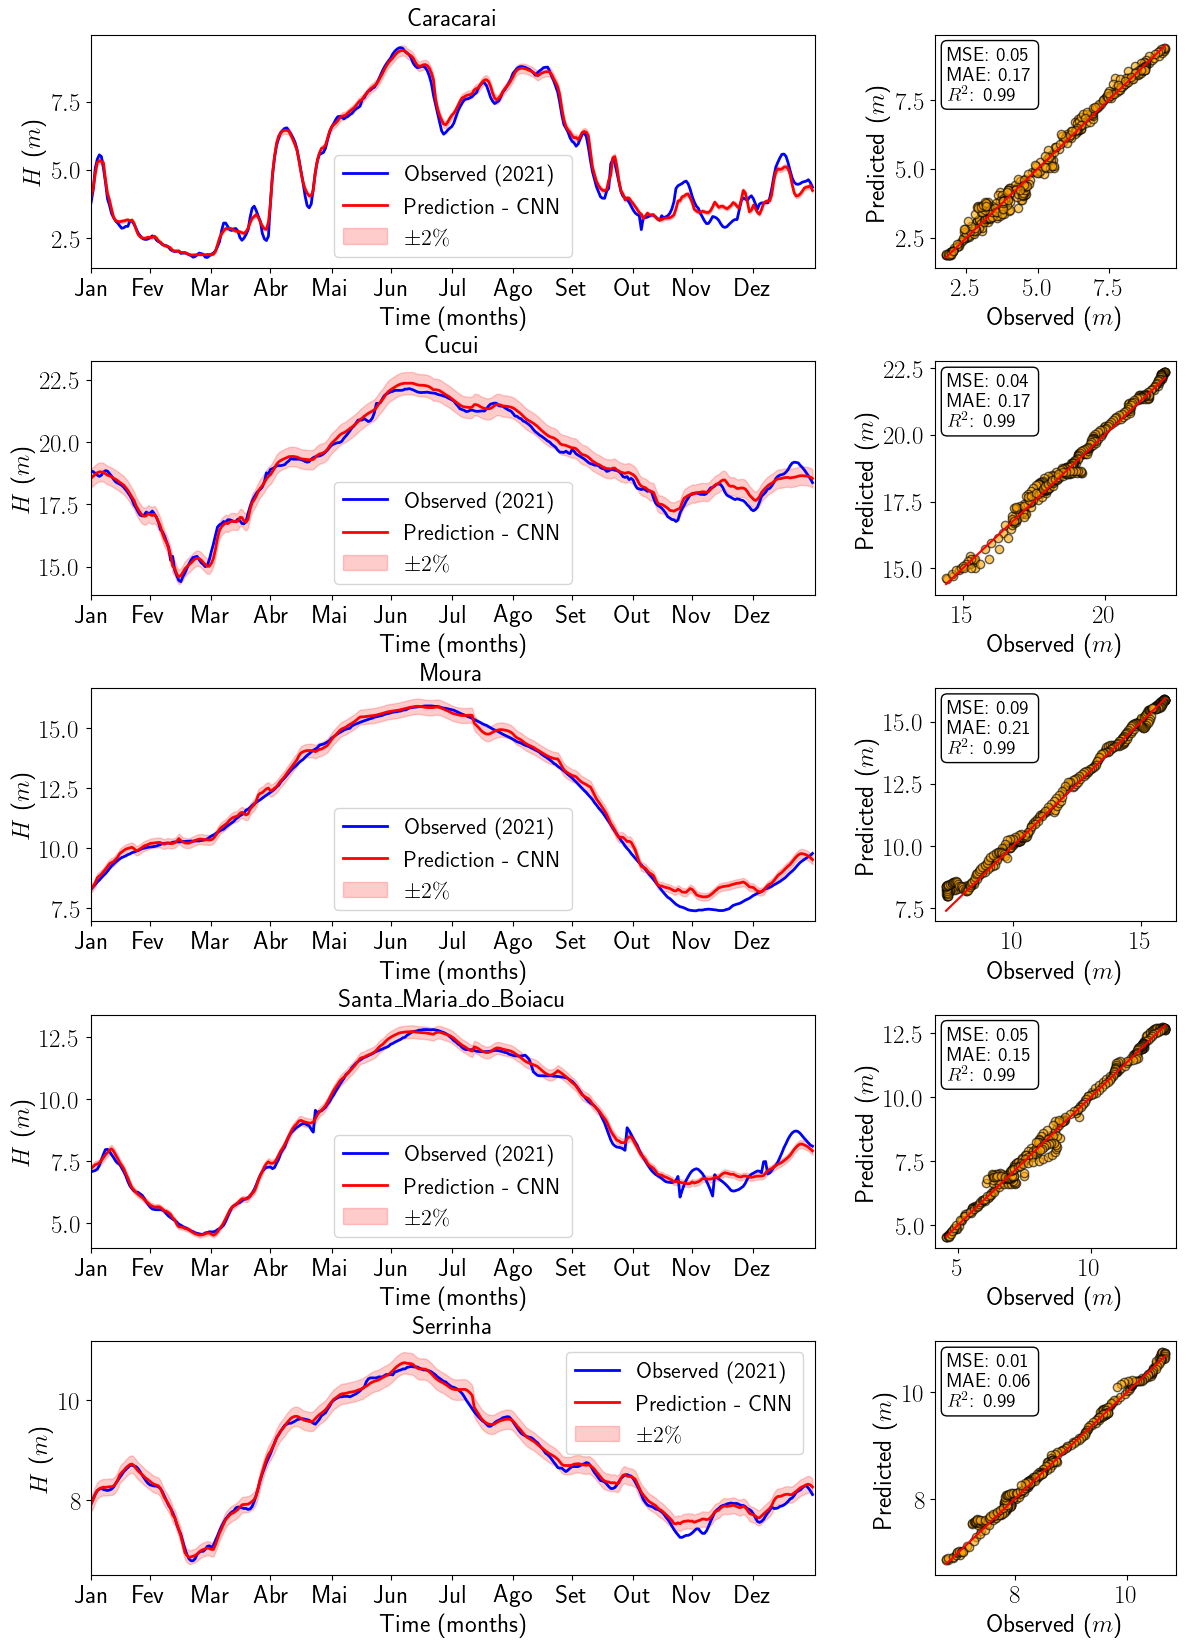

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 15})
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16

# Número de estações
station_list = list(stations.keys())
n_stations = len(station_list)

fig, axs = plt.subplots(
    n_stations, 2,
    figsize=(14, n_stations * 4),
    gridspec_kw={'width_ratios': [3, 1], 'wspace': 0.25, 'hspace': 0.4}
)

months = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

# Pré-calcular TODAS as previsões (modelo global gera 5 saídas)
X_inputs = {f"input_{s}": station_data[s][0] for s in stations}
all_preds = model.predict(X_inputs)

# Mapa estação → índice da saída
station_index = {st: i for i, st in enumerate(station_list)}

for i, station in enumerate(station_list):

    X_test, Y_test, scaler_y = station_data[station]

    # pegar a saída correta desta estação
    preds_scaled = all_preds[station_index[station]]

    preds = scaler_y.inverse_transform(preds_scaled)
    Y_real = scaler_y.inverse_transform(Y_test)

    # métricas
    mse  = mean_squared_error(Y_real, preds)
    mae  = mean_absolute_error(Y_real, preds)
    rmse = np.sqrt(mse)
    r2   = r2_score(Y_real, preds)

    # tamanho correto da série
    n_points = len(preds)
    x_axis = np.arange(n_points)

    # faixa ±2%
    lower = preds.flatten() * 0.98
    upper = preds.flatten() * 1.02

    # ---- GRÁFICO DA CURVA (COLUNA 0) ----
    axs[i, 0].plot(x_axis, Y_real.flatten(), label="Observed (2021)", color='blue', linewidth=2)
    axs[i, 0].plot(x_axis, preds.flatten(), label="Prediction - CNN", color='red', linewidth=2)
    axs[i, 0].fill_between(x_axis, lower, upper, color='red', alpha=0.2, label="$\pm 2\%$")

    axs[i, 0].set_title(station)
    axs[i, 0].set_xlabel("Time (months)")
    axs[i, 0].set_ylabel("$H$ ($m$)")

    # Ajuste dos ticks do eixo X baseado no tamanho da série
    axs[i, 0].set_xticks([int(j * (n_points / 12)) for j in range(12)])
    axs[i, 0].set_xticklabels(months)

    axs[i, 0].set_xlim(0, n_points)
    axs[i, 0].legend()

    # ---- GRÁFICO DE DISPERSÃO (COLUNA 1) ----
    axs[i, 1].scatter(Y_real, preds, alpha=0.6, edgecolor='k', facecolor='orange')
    axs[i, 1].plot([Y_real.min(), Y_real.max()],
                   [Y_real.min(), Y_real.max()],
                   color='red', linestyle='-')

    axs[i, 1].set_xlabel("Observed ($m$)")
    axs[i, 1].set_ylabel("Predicted ($m$)")

    # Caixa de métricas
    textstr = f"MSE: {mse:.2f}\nMAE: {mae:.2f}\n$R^2$: {r2:.2f}"
    axs[i, 1].text(0.05, 0.95, textstr,
                   transform=axs[i, 1].transAxes,
                   fontsize=14, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black"))

# Salvar
plt.tight_layout()
plt.savefig("prediction_individual_ranges.pdf", format="pdf", bbox_inches="tight")
plt.show()
